In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import truncnorm

In [3]:
data = pd.DataFrame()

In [24]:
def cuped(data,pre,post,model):
    cov = np.cov(data[pre],data[post])[0][1]
    var = np.var(data[pre])
    theta = cov/var
    data[model+ '_' +post] = data[post]- theta*data[pre]
    var_ori = np.var(data[post])
    var_cuped = np.var(data[model + '_'+post])
    print(model + ' variance reduction rate：',1-var_cuped/var_ori)
    return data,theta

In [25]:
import pandas as pd
import numpy as np

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import xgboost as xgb
import matplotlib.pyplot as plt
import pickle


from sklearn.metrics import r2_score

In [37]:
def itr_xgb(train,test,key,post,model):
    xgb_model_1 = xgb.XGBRegressor(
                max_depth = 4,
                # objective='reg:squarederror', 
                objective='reg:tweedie',
                tweedie_variance_power = 1.7,
                eval_metric = "rmse",
                booster='gbtree',
                n_estimators = 500,
                # grow_policy = 'lossguide',
                early_stopping_rounds=20,
                importance_type = 'gain',
                learning_rate = 0.05,
                min_child_weight=2,
                gamma = 0.2,
                subsample=0.5,
                colsample_bytree=0.8,
                reg_alpha=0.1,
                reg_lambda=1,
                random_state=0)
    print('build data')
    fold_feature,fold_label = build_data(train,key,post)
    print('train test split')
    X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(fold_feature, fold_label, test_size=0.2, random_state=0)

    print('model fitting')
    xgb_model_1.fit(X_train_1,y_train_1,eval_set=[(X_test_1, y_test_1)])
    y_hat_test = xgb_model_1.predict(X_test_1)
    y_hat_train = xgb_model_1.predict(fold_feature)
    r2_y_test = r2_score(y_test_1, y_hat_test)
    r2_y_train = r2_score(fold_label, y_hat_train)
    # r2_y_test_cat = r2_score(y_test_1, y_hat_test_cat)
    print('train set',r2_y_train,'predict set',r2_y_test)
    featr , lab = build_data(test,key,post)
    y_hat = xgb_model_1.predict(featr)
    r2_y_pred = r2_score(y_hat, lab)
    # print(r2_y_pred)

    train[post+'_y_hat_xgb'] = y_hat_train
    test[post+'_y_hat_xgb'] = y_hat
    test = cuped(test,post+'_y_hat_xgb',post,model)
    return train,test

In [38]:
def build_data(df,featurelist,post):
    fea = df.loc[:,featurelist].values
    lab = df.loc[:,post].values   # 2-fold
    
    return fea,lab

(array([  54.,  416.,  118.,   96.,  135.,  214.,  284.,  272.,  276.,
         361.,  329.,  374.,  460.,  581., 1285., 1454., 1153., 1180.,
         847.,  111.]),
 array([ 0.14731955,  0.96390619,  1.78049284,  2.59707949,  3.41366614,
         4.23025279,  5.04683943,  5.86342608,  6.68001273,  7.49659938,
         8.31318603,  9.12977267,  9.94635932, 10.76294597, 11.57953262,
        12.39611927, 13.21270592, 14.02929256, 14.84587921, 15.66246586,
        16.47905251]),
 <BarContainer object of 20 artists>)

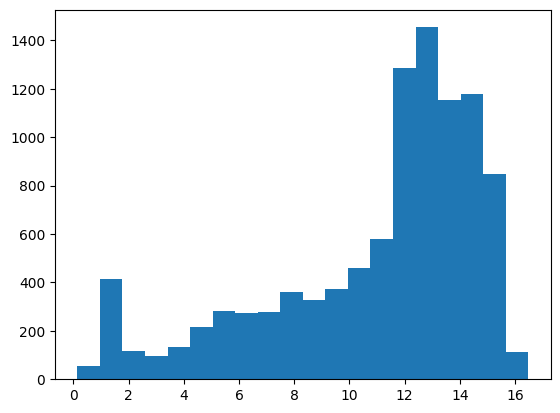

In [39]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt


np.random.seed(42)

values = [0] + list(range(1, 13)) + [13, 14]
probabilities = [0.05] + [0.02] * 12 + [0.31, 0.40]
assert sum(probabilities) == 1.0, "Probabilities must sum to 1."
def simulate_user_frequencies(num_users):
    return np.random.choice(values, size=num_users, p=probabilities)
num_users = 10000
x = simulate_user_frequencies(num_users)
x2 = simulate_user_frequencies(num_users)
data_1 = pd.DataFrame()
data_1['x1'] = x
data_1['x2'] = x2
data_1[['x3', 'x4','noise']] = np.random.normal(loc=5.0, scale=1.0, size=(10000, 3))
data_1['y'] = 0.4*(data_1['x1']) + np.sqrt(data_1['x1'] * np.abs(data_1['x2']))/2 -  np.sqrt(np.abs(data_1['x4'])*np.abs(data_1['x3']))/20 + 1.5* np.sin(math.pi * data_1['x1'] * data_1['x4']) + np.abs(data_1['noise'])/3
data_1['enter_date'] = 1
plt.hist(data_1['y'],bins = 20)


In [40]:
cuped(data_1,'x1','y','cuped')
key = ['x1','x2','x3','x4']
post = 'y'
test = data_1.sample(frac=0.2, random_state=0)
train = data_1.drop(test.index)
train,test = itr_xgb(train,test,key,post,'ITR')

cuped variance reduction rate： 0.7302573561835997
build data
train test split
model fitting
[0]	validation_0-rmse:8.19347
[1]	validation_0-rmse:8.04224
[2]	validation_0-rmse:7.88964


[3]	validation_0-rmse:7.73351
[4]	validation_0-rmse:7.57477
[5]	validation_0-rmse:7.41618
[6]	validation_0-rmse:7.25530
[7]	validation_0-rmse:7.09147
[8]	validation_0-rmse:6.92893
[9]	validation_0-rmse:6.76313
[10]	validation_0-rmse:6.59676
[11]	validation_0-rmse:6.43178
[12]	validation_0-rmse:6.26429
[13]	validation_0-rmse:6.09696
[14]	validation_0-rmse:5.93006
[15]	validation_0-rmse:5.76783
[16]	validation_0-rmse:5.60722
[17]	validation_0-rmse:5.45549
[18]	validation_0-rmse:5.29309
[19]	validation_0-rmse:5.13264
[20]	validation_0-rmse:4.97445
[21]	validation_0-rmse:4.81837
[22]	validation_0-rmse:4.66915
[23]	validation_0-rmse:4.53141
[24]	validation_0-rmse:4.39672
[25]	validation_0-rmse:4.25094
[26]	validation_0-rmse:4.12319
[27]	validation_0-rmse:3.98393
[28]	validation_0-rmse:3.86144
[29]	validation_0-rmse:3.73364
[30]	validation_0-rmse:3.60396
[31]	validation_0-rmse:3.49189
[32]	validation_0-rmse:3.36908
[33]	validation_0-rmse:3.25546
[34]	validation_0-rmse:3.14069
[35]	validation

(array([ 460.,  209.,  340.,  566.,  611.,  692.,  938., 2618., 2576.,
         990.]),
 array([0.07365977, 0.88193203, 1.69020429, 2.49847655, 3.3067488 ,
        4.11502106, 4.92329332, 5.73156558, 6.53983783, 7.34811009,
        8.15638235]),
 <BarContainer object of 10 artists>)

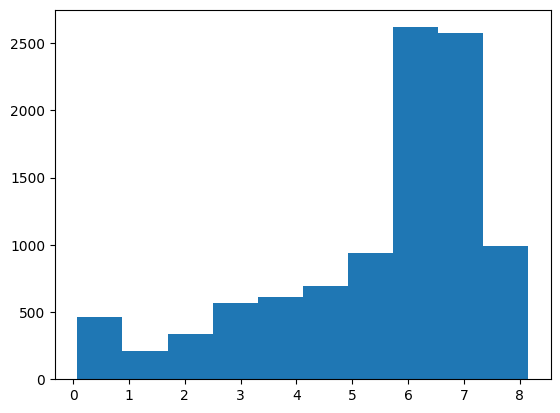

In [31]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt


np.random.seed(42)

values = [0] + list(range(1, 13)) + [13, 14]
probabilities = [0.05] + [0.02] * 12 + [0.31, 0.40]

# 确保概率总和为1
assert sum(probabilities) == 1.0, "Probabilities must sum to 1."

def simulate_user_frequencies(num_users):
    return np.random.choice(values, size=num_users, p=probabilities)

num_users = 10000
x = simulate_user_frequencies(num_users)
x2 = simulate_user_frequencies(num_users)
data_2 = pd.DataFrame()
data_2['x1'] = x
data_2['x2'] = x2
data_2[['x3', 'x4','noise']] = np.random.normal(loc=5.0, scale=1.0, size=(10000, 3))
data_2['y'] = 0.2*(data_2['x1']) + np.sqrt(data_2['x1'] * np.abs(data_2['x2']))/4 -  np.sqrt(np.abs(data_2['x4'])*np.abs(data_2['x3']))/40 + np.sin(math.pi * data_2['x1'] * data_2['x4'])/1.5 + np.abs(data_2['noise'])/6
data_2['enter_date'] = 0
plt.hist(data_2['y'])


In [41]:
data = pd.concat([data_1,data_2])
cuped(data,'x1','y','cuped')
key = ['x1','x2','x3','x4']
post = 'y'
test = data.sample(frac=0.2, random_state=0)
train = data.drop(test.index)
train,test = itr_xgb(train,test,key,post,'ITR')

cuped variance reduction rate： 0.3607682292064781
build data
train test split
model fitting
[0]	validation_0-rmse:6.21223
[1]	validation_0-rmse:6.10197


[2]	validation_0-rmse:5.99363
[3]	validation_0-rmse:5.88444
[4]	validation_0-rmse:5.77571
[5]	validation_0-rmse:5.66885
[6]	validation_0-rmse:5.56301
[7]	validation_0-rmse:5.45508
[8]	validation_0-rmse:5.35132
[9]	validation_0-rmse:5.24610
[10]	validation_0-rmse:5.14296
[11]	validation_0-rmse:5.04484
[12]	validation_0-rmse:4.94485
[13]	validation_0-rmse:4.84759
[14]	validation_0-rmse:4.75234
[15]	validation_0-rmse:4.66309
[16]	validation_0-rmse:4.57636
[17]	validation_0-rmse:4.49834
[18]	validation_0-rmse:4.41202
[19]	validation_0-rmse:4.33006
[20]	validation_0-rmse:4.24910
[21]	validation_0-rmse:4.17276
[22]	validation_0-rmse:4.10301
[23]	validation_0-rmse:4.04071
[24]	validation_0-rmse:3.98203
[25]	validation_0-rmse:3.91706
[26]	validation_0-rmse:3.86396
[27]	validation_0-rmse:3.80562
[28]	validation_0-rmse:3.75777
[29]	validation_0-rmse:3.70767
[30]	validation_0-rmse:3.65629
[31]	validation_0-rmse:3.61665
[32]	validation_0-rmse:3.57209
[33]	validation_0-rmse:3.53310
[34]	validation_

In [42]:
def multi_cuped(data,X,Y,enter_days,model):
    mean_Y = data[Y].mean()
    mean_x1 = data[X].mean()
    mean_x2 = data[enter_days].mean()

    # Calculate covariances
    cov_Y_x1 = ((data[Y] - mean_Y) * (data[X] - mean_x1)).mean()
    cov_Y_x2 = ((data[Y] - mean_Y) * (data[enter_days] - mean_x2)).mean()
    cov_x1_x2 = ((data[X] - mean_x1) * (data[enter_days] - mean_x2)).mean()

    # Calculate variances
    var_x1 = ((data[X] - mean_x1)**2).mean()
    var_x2 = ((data[enter_days] - mean_x2)**2).mean()

    # Calculate beta coefficients
    theta_1 = (cov_Y_x1 * var_x2 - cov_x1_x2 * cov_Y_x2) / (var_x1 * var_x2 - cov_x1_x2**2)
    theta_2 = (cov_Y_x2 * var_x1 - cov_x1_x2 * cov_Y_x1) / (var_x1 * var_x2 - cov_x1_x2**2)

    data[model] = data[Y] - theta_1*data[X] - theta_2*data[enter_days]
    var_ori = np.var(data[post])
    var_cuped = np.var(data[model])
    print(model + ' variance reduction rate：',1-var_cuped/var_ori)
    
    return theta_1,theta_2

In [43]:
multi_cuped(data,'x1','y','enter_date','multi cuped')
key = ['x1','x2','x3','x4','enter_date']
post = 'y'
test = data.sample(frac=0.2, random_state=0)
train = data.drop(test.index)
train,test = itr_xgb(train,test,key,post,'multi ITR')

multi cuped variance reduction rate： 0.813535523235394
build data
train test split
model fitting
[0]	validation_0-rmse:6.20592
[1]	validation_0-rmse:6.08862
[2]	validation_0-rmse:5.97768
[3]	validation_0-rmse:5.86975
[4]	validation_0-rmse:5.74910
[5]	validation_0-rmse:5.62719
[6]	validation_0-rmse:5.51507
[7]	validation_0-rmse:5.40300
[8]	validation_0-rmse:5.29059
[9]	validation_0-rmse:5.16790
[10]	validation_0-rmse:5.05508
[11]	validation_0-rmse:4.94234
[12]	validation_0-rmse:4.81767
[13]	validation_0-rmse:4.69462
[14]	validation_0-rmse:4.58600
[15]	validation_0-rmse:4.47493
[16]	validation_0-rmse:4.35215
[17]	validation_0-rmse:4.24792
[18]	validation_0-rmse:4.14496
[19]	validation_0-rmse:4.02808
[20]	validation_0-rmse:3.91215
[21]	validation_0-rmse:3.80768
[22]	validation_0-rmse:3.69532
[23]	validation_0-rmse:3.58180
[24]	validation_0-rmse:3.47344
[25]	validation_0-rmse:3.36693
[26]	validation_0-rmse:3.25977
[27]	validation_0-rmse:3.15756
[28]	validation_0-rmse:3.07436
[29]	validatio